In [62]:
import pandas as pd
from itertools import combinations
import rna_seq_functions as rna
import importlib
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyensembl
import json
import plot_formatters as fmt
import aggregate_functions as agg
import os

In [63]:
scramble_data_dir = '/Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/scrambles'
experiment_data_dir = '/Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/experiments/bridged'
gene_list_dir = '/Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/filtered_gene_lists'

percent_cell_threshold = .5
umi_threshold = 3
gene_set_length = 535


gene_list_file_name = os.path.join(
    gene_list_dir,
    'filtered_gene-list_pcells-' \
    + str(percent_cell_threshold) \
    + '_umicount-' + str(umi_threshold) \
    + '_len-' + str(gene_set_length) + '.npy'
)
COLOR_PALETTES = json.load(open('lib/color_palettes.json', 'r'))

In [64]:
vals = np.load(gene_list_file_name, allow_pickle=True)
vals = vals.tolist()
gene_ids = [v.decode("utf-8") for v in vals]
with open('aging_gene_ids_background.txt', 'w') as f:
    for gene_id in gene_ids:
        f.write(gene_id + '\n')

In [65]:
replicates = [f.split('_')[0] for f in os.listdir(experiment_data_dir) if f.split('.')[-1] == 'csv']
replicates

['AN8', 'AN9']

# Figure 4: Bootstrap isolated clones

In [66]:
gr_labels_df = pd.read_csv('/Users/akre96/Data/HSC_aging_project/aging_and_10x/Graphs/hsc_to_ct_bootstrap/gr_hsc_bound_labels.csv')
gr_labels_df['label_name'] = gr_labels_df['in_boundary'].map({False: 'not_expanded', True: 'hsc_expanded'})
gr_labels_df = gr_labels_df[['code', 'label_name']]
gr_labels = gr_labels_df.label_name.unique()
label_comparisons = list(combinations(gr_labels, 2))
print(label_comparisons)
gr_labels_df.groupby('label_name').code.nunique()

[('not_expanded', 'hsc_expanded')]


label_name
hsc_expanded      47
not_expanded    1021
Name: code, dtype: int64

In [67]:
importlib.reload(rna)
print(label_comparisons)
comparison_df, mapped_clones, experiment_rna_data_df = rna.generate_rna_seq_label_comparison_df(
    experiment_data_dir,
    scramble_data_dir,
    replicates,
    n_scrambles=5,
    labels_df=gr_labels_df,
    label_comparisons=label_comparisons,
    filter_genes=True,
    filter_genes_path=gene_list_file_name
)

[('not_expanded', 'hsc_expanded')]
Filtering Genes Using List From: /Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/filtered_gene_lists/filtered_gene-list_pcells-0.5_umicount-3_len-535.npy
Working on: AN8 experiment ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'hsc_expanded')
Done.
Working on: AN8 scramble-0 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'hsc_expanded')
Done.
Working on: AN8 scramble-1 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'hsc_expanded')
Done.
Working on: AN8 scramble-2 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'hsc_expanded')
Done.
Working on: AN8 scramble-3 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285

In [68]:
comparison_df[comparison_df.experiment_type == 'experiment'][['replicate', 'experiment_type' ,'comparison', 'count_0', 'count_1', 'l0', 'l1']].drop_duplicates().sort_values(by=['replicate', 'comparison'])

,replicate,experiment_type,comparison,count_0,count_1,l0,l1
0,AN8,experiment,not_expanded vs hsc_expanded,26,2,not_expanded,hsc_expanded
0,AN9,experiment,not_expanded vs hsc_expanded,160,50,not_expanded,hsc_expanded


In [69]:
importlib.reload(rna)

isolate_replicate_cols = [
    'gene_id',
    'experiment_type',
    'comparison']

start = time.process_time()

replicate_combined_df = rna.combine_group_p_values(
    comparison_df,
    isolate_replicate_cols
)
stop = time.process_time()
print('Time Elapsed:', stop - start, 'seconds')

Time Elapsed: 3.235352000000006 seconds


# of P-Values: 535
# of P-Values less than or equal to  0.1 57
# of P-Values: 535
# of P-Values less than or equal to  0.1 46
Time Elapsed: 0.2644420000000025 seconds


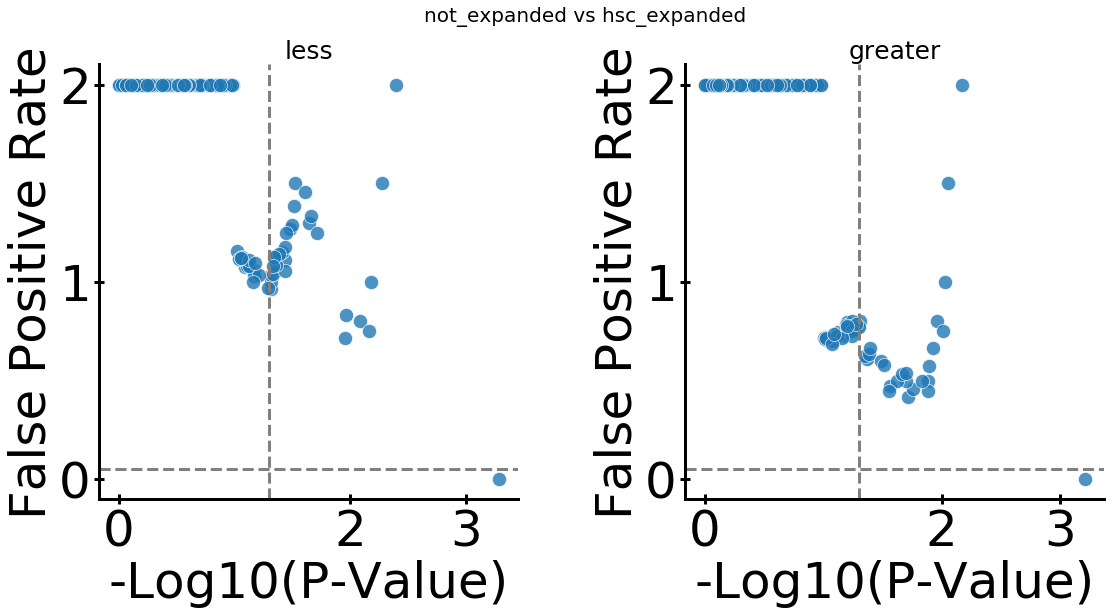

In [70]:
importlib.reload(rna)
experiment_with_fpr_df = rna.calc_fpr_both_directions(replicate_combined_df, p_value_cutoff=0.1)
experiment_with_fpr_df = rna.add_mouse_gene_names(experiment_with_fpr_df)
mpl.rcParams['font.size'] = 50

for comp, c_df in experiment_with_fpr_df.groupby('comparison'):
    fig, axes = rna.plot_false_positive_scores(c_df)
    plt.suptitle(comp, fontsize=20)

In [71]:
pass_fpr_and_p_df = rna.filt_false_positive_p(experiment_with_fpr_df)
pass_fpr_and_p_df[['comparison', 'gene_name','p_value_greater', 'p_value_less', 'log2fc', 'fold_change', 'p_value_greater_fpr', 'p_value_less_fpr']].dropna()

,comparison,gene_name,p_value_greater,p_value_less,log2fc,fold_change,p_value_greater_fpr,p_value_less_fpr
28,not_expanded vs hsc_expanded,Prdx2,0.999842,0.000526,-1.164813,0.486046,2.0,0.0
435,not_expanded vs hsc_expanded,Rpl26,0.000621,0.917561,0.153791,1.114423,0.0,2.0


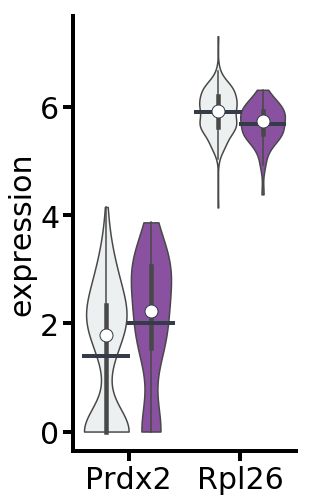

In [72]:
sig_genes = pass_fpr_and_p_df[['comparison','gene_name', 'gene_id', 'fold_change']].dropna()
sig_genes = sig_genes[sig_genes.gene_name != 'Xist']
sig_gene_expression = experiment_rna_data_df.merge(
    sig_genes,
    how='inner',
    validate='m:m'
)
importlib.reload(rna)
mpl.rcParams['font.size'] = 30
rna.plot_sig_genes(
    sig_gene_expression,
    comp=['not_expanded', 'hsc_expanded'],
    palette=['#ecf0f1', '#8e44ad'],
    linewidth=4
)

# Figure 4: expanded clones

In [85]:
expand_labels = pd.read_csv('/Users/akre96/Data/HSC_aging_project/aging_and_10x/Graphs/clone_count_bar/expanded_first_last_labels.csv')
expand_labels.head()

,code,group,cell_type,mouse_id,is_expanded
0,ACTCAGCGTGGAGGAAGCAGTGATGTGGGGAAAAGATCGGAAGAGC...,no_change,gr,M190,not_expanded
1,ACTCAGCGTGGAGGAAGCAGTGATGTGGGGAAAAGATCGGAAGAGC...,no_change,b,M190,not_expanded
2,ACTCAGGCGCCTGTGGGTTGAGTCGGCCATCTCAGATCGGAAGAGC...,no_change,gr,M190,not_expanded
3,ACTCAGGCGCCTGTGGGTTGAGTCGGCCATCTCAGATCGGAAGAGC...,no_change,b,M190,not_expanded
4,ACTCAGGCATCGTCGTCAGATTACTTGGGCGCGAGATCGGAAGAGC...,no_change,gr,M190,not_expanded


In [97]:
cell_type = 'gr'
ct_labels_df = expand_labels[expand_labels.cell_type == cell_type][['code', 'mouse_id', 'group', 'is_expanded']].rename(columns={'is_expanded': 'label_name'})

In [98]:
ct_labels = ct_labels_df.label_name.unique()
label_comparisons = list(combinations(ct_labels, 2))
print(label_comparisons)
ct_labels_df.groupby('label_name').code.nunique()

[('not_expanded', 'Expanded')]


label_name
Expanded         225
not_expanded    3310
Name: code, dtype: int64

In [99]:
importlib.reload(rna)
print(label_comparisons)
comparison_df, mapped_clones, experiment_rna_data_df = rna.generate_rna_seq_label_comparison_df(
    experiment_data_dir,
    scramble_data_dir,
    replicates,
    n_scrambles=5,
    labels_df=ct_labels_df,
    label_comparisons=label_comparisons,
    filter_genes=True,
    filter_genes_path=gene_list_file_name
)

[('not_expanded', 'Expanded')]
Filtering Genes Using List From: /Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/filtered_gene_lists/filtered_gene-list_pcells-0.5_umicount-3_len-535.npy
Working on: AN8 experiment ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'Expanded')
Done.
Working on: AN8 scramble-0 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'Expanded')
Done.
Working on: AN8 scramble-1 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'Expanded')
Done.
Working on: AN8 scramble-2 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('not_expanded', 'Expanded')
Done.
Working on: AN8 scramble-3 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('no

In [100]:
comparison_df[comparison_df.experiment_type == 'experiment'][['replicate', 'experiment_type' ,'comparison', 'count_0', 'count_1', 'l0', 'l1']].drop_duplicates().sort_values(by=['replicate', 'comparison'])

,replicate,experiment_type,comparison,count_0,count_1,l0,l1
0,AN8,experiment,not_expanded vs Expanded,9,20,not_expanded,Expanded
0,AN9,experiment,not_expanded vs Expanded,110,109,not_expanded,Expanded


In [101]:
experiment_rna_data_df.groupby(['mouse_id', 'group'])[['CBC', 'code']].nunique()

,,CBC,code
mouse_id,group,,
M2012,aging_phenotype,29,9
M2059,aging_phenotype,122,22
M2061,no_change,97,16


In [91]:
importlib.reload(rna)

isolate_replicate_cols = [
    'gene_id',
    'experiment_type',
    'comparison']

start = time.process_time()

replicate_combined_df = rna.combine_group_p_values(
    comparison_df,
    isolate_replicate_cols
)
stop = time.process_time()
print('Time Elapsed:', stop - start, 'seconds')

Time Elapsed: 3.264611000000002 seconds


# of P-Values: 535
# of P-Values less than or equal to  0.1 41
# of P-Values: 535
# of P-Values less than or equal to  0.1 61
Time Elapsed: 0.26981000000000677 seconds


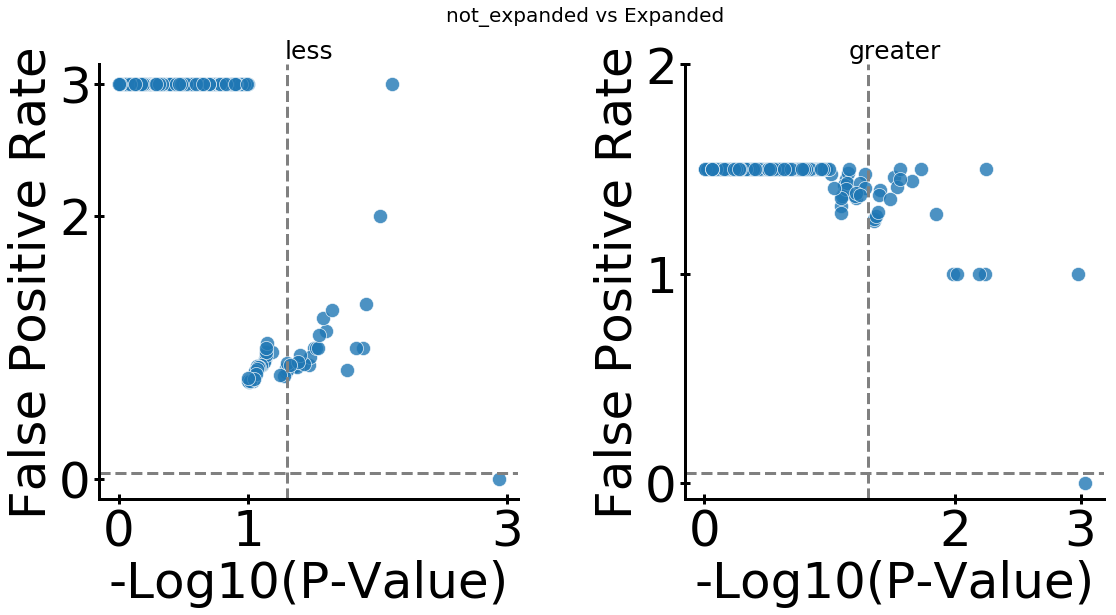

In [92]:
importlib.reload(rna)
experiment_with_fpr_df = rna.calc_fpr_both_directions(replicate_combined_df, p_value_cutoff=0.1)
experiment_with_fpr_df = rna.add_mouse_gene_names(experiment_with_fpr_df)
mpl.rcParams['font.size'] = 50

for comp, c_df in experiment_with_fpr_df.groupby('comparison'):
    fig, axes = rna.plot_false_positive_scores(c_df)
    plt.suptitle(comp, fontsize=20)

In [93]:
pass_fpr_and_p_df = rna.filt_false_positive_p(experiment_with_fpr_df)
pass_fpr_and_p_df[['comparison', 'gene_name','p_value_greater', 'p_value_less', 'log2fc', 'fold_change', 'p_value_greater_fpr', 'p_value_less_fpr']].dropna()

,comparison,gene_name,p_value_greater,p_value_less,log2fc,fold_change,p_value_greater_fpr,p_value_less_fpr
341,not_expanded vs Expanded,Rpl7,0.987147,0.001166,-0.172698,0.887227,1.5,0.0
522,not_expanded vs Expanded,Myl6,0.000930,0.999615,0.711743,1.699695,0.0,3.0


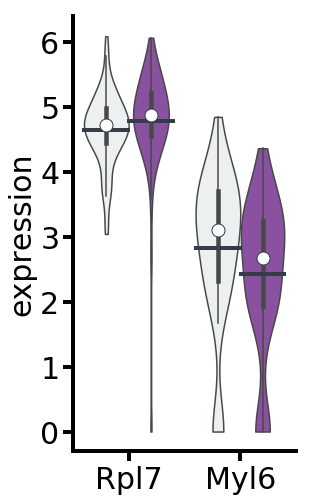

In [94]:
sig_genes = pass_fpr_and_p_df[['comparison','gene_name', 'gene_id', 'fold_change']].dropna()
sig_genes = sig_genes[sig_genes.gene_name != 'Xist']
sig_gene_expression = experiment_rna_data_df.merge(
    sig_genes,
    how='inner',
    validate='m:m'
)
importlib.reload(rna)
mpl.rcParams['font.size'] = 30
rna.plot_sig_genes(
    sig_gene_expression,
    comp=['not_expanded', 'Expanded'],
    palette=['#ecf0f1', '#8e44ad'],
    linewidth=4
)

# Figure 3 Related SC-RNASeq

In [21]:
change_labels = pd.read_csv('/Users/akre96/Data/HSC_aging_project/aging_and_10x/Graphs/hsc_abundance_by_change/0-05/changed_labels.csv')
change_labels.head()

,code,group,mouse_id,change_type,change_status
0,TGTTACGAGATCAAGAGTACAGTGCGGGGTAGGAGATCGGAAGAGC...,aging_phenotype,M3007,Myeloid,Changed
1,TGTTACGAATCCGAGTCTAGGGTGTCATAGCGGAGATCGGAAGAGC...,aging_phenotype,M3007,Unchanged,Unchanged
2,TGTTACGGTCGTTTTCGTACGGTTGGTTATCGAAGATCGGAAGAGC...,aging_phenotype,M3007,Myeloid,Changed
3,TGTTACGGCTCAACTTGGGTGTGGGCGGATGATAGATCGGAAGAGC...,aging_phenotype,M3007,Myeloid,Changed
4,TGTTACACGGTGAGGTCTGAGGGCCTGTCAGTAAGATCGGAAGAGC...,aging_phenotype,M3007,Unchanged,Unchanged


## Compare Stable/Changing clones -- DMOLD

In [56]:
group = 'no_change'
group_change_labels_df = change_labels[change_labels.group == group][['code', 'change_type']].drop_duplicates()\
    .rename(columns={'change_type': 'label_name'})
group_change_type_labels = group_change_labels_df.label_name.unique()
label_comparisons = list(combinations(group_change_type_labels, 2))
print(label_comparisons)
group_change_labels_df.groupby('label_name').code.nunique()

[('Unchanged', 'Myeloid'), ('Unchanged', 'Lymphoid'), ('Myeloid', 'Lymphoid')]


label_name
Lymphoid     146
Myeloid       66
Unchanged    350
Name: code, dtype: int64

In [57]:
importlib.reload(rna)
print(label_comparisons)
comparison_df, mapped_clones, experiment_rna_data_df = rna.generate_rna_seq_label_comparison_df(
    experiment_data_dir,
    scramble_data_dir,
    replicates,
    n_scrambles=5,
    labels_df=group_change_labels_df,
    label_comparisons=label_comparisons,
    filter_genes=True,
    filter_genes_path=gene_list_file_name
)

[('Unchanged', 'Myeloid'), ('Unchanged', 'Lymphoid'), ('Myeloid', 'Lymphoid')]
Filtering Genes Using List From: /Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/filtered_gene_lists/filtered_gene-list_pcells-0.5_umicount-3_len-535.npy
Working on: AN8 experiment ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('Unchanged', 'Myeloid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
	...Comparing: ('Unchanged', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
	...Comparing: ('Myeloid', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
Done.
Working on: AN8 scramble-0 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('Unchanged', 'Myeloid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
	...Comparing: ('Unchanged', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
	...Comparing: ('Myeloid', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
Done.
Working on: AN8 scramble-1 ...
	...Importi

In [58]:
comparison_df[comparison_df.experiment_type == 'experiment'][['replicate', 'experiment_type' ,'comparison', 'count_0', 'count_1', 'l0', 'l1']].drop_duplicates().sort_values(by=['replicate', 'comparison'])

,replicate,experiment_type,comparison,count_0,count_1,l0,l1
0,AN9,experiment,Unchanged vs Lymphoid,78,19,Unchanged,Lymphoid


# of P-Values: 522
# of P-Values less than or equal to  0.1 58
# of P-Values: 522
# of P-Values less than or equal to  0.1 50
Time Elapsed: 0.31629200000000424 seconds


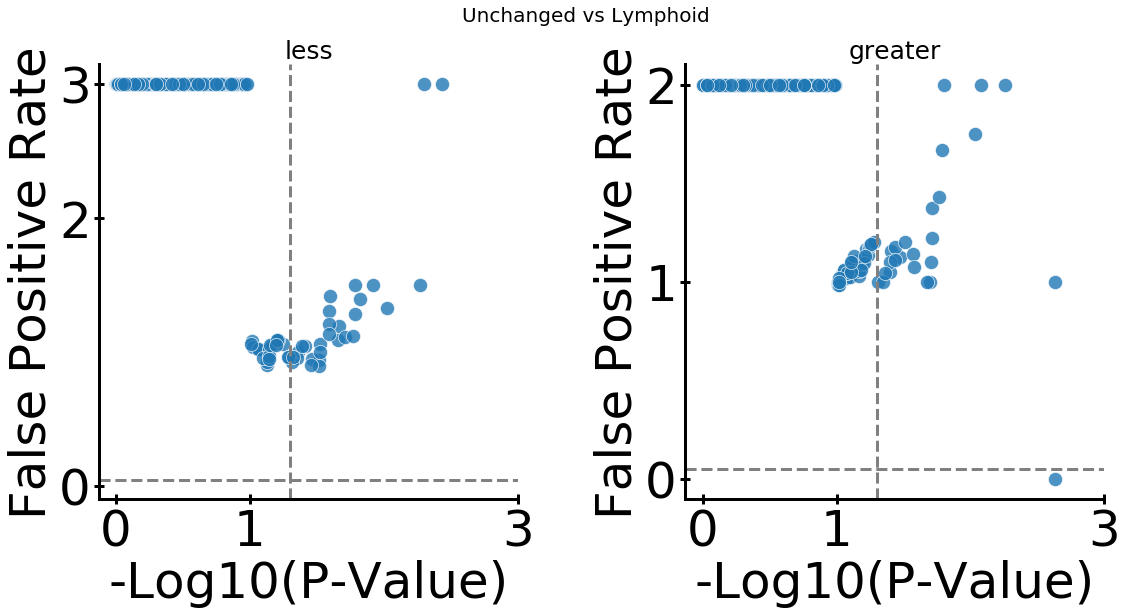

In [59]:
importlib.reload(rna)
experiment_with_fpr_df = rna.calc_fpr_both_directions(comparison_df, p_value_cutoff=0.1)
experiment_with_fpr_df = rna.add_mouse_gene_names(experiment_with_fpr_df)
mpl.rcParams['font.size'] = 50

for comp, c_df in experiment_with_fpr_df.groupby('comparison'):
    fig, axes = rna.plot_false_positive_scores(c_df)
    plt.suptitle(comp, fontsize=20)

In [60]:
pass_fpr_and_p_df = rna.filt_false_positive_p(experiment_with_fpr_df)
pass_fpr_and_p_df[['comparison', 'gene_name','p_value_greater', 'p_value_less', 'log2fc', 'fold_change', 'p_value_greater_fpr', 'p_value_less_fpr']].dropna()

,comparison,gene_name,p_value_greater,p_value_less,log2fc,fold_change,p_value_greater_fpr,p_value_less_fpr
423,Unchanged vs Lymphoid,Rpl11,0.002317,0.997748,0.549717,1.463799,0.0,3.0


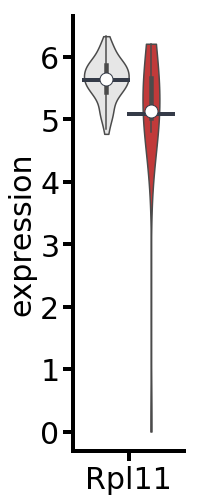

In [61]:
sig_genes = pass_fpr_and_p_df[['comparison','gene_name', 'gene_id', 'fold_change']].dropna()
sig_genes = sig_genes[sig_genes.gene_name != 'Xist']
sig_gene_expression = experiment_rna_data_df.merge(
    sig_genes,
    how='inner',
    validate='m:m'
)
importlib.reload(rna)
mpl.rcParams['font.size'] = 30
rna.plot_sig_genes(
    sig_gene_expression,
    comp=['Unchanged', 'Lymphoid'],
    palette=COLOR_PALETTES['change_type'],
    linewidth=4
)

## Compare Stable/Changing clones all mice

In [50]:
change_labels_df = change_labels[['mouse_id', 'group', 'code', 'change_type']].drop_duplicates()\
    .rename(columns={'change_type': 'label_name'})
change_type_labels = change_labels_df.label_name.unique()
label_comparisons = list(combinations(change_type_labels, 2))
print(label_comparisons)
change_labels_df.groupby('label_name').code.nunique()

[('Myeloid', 'Unchanged'), ('Myeloid', 'Lymphoid'), ('Unchanged', 'Lymphoid')]


label_name
Lymphoid     195
Myeloid      244
Unchanged    795
Name: code, dtype: int64

In [51]:
importlib.reload(rna)
print(label_comparisons)
comparison_df, mapped_clones, experiment_rna_data_df = rna.generate_rna_seq_label_comparison_df(
    experiment_data_dir,
    scramble_data_dir,
    replicates,
    n_scrambles=5,
    labels_df=change_labels_df,
    label_comparisons=label_comparisons,
    filter_genes=True,
    filter_genes_path=gene_list_file_name
)

[('Myeloid', 'Unchanged'), ('Myeloid', 'Lymphoid'), ('Unchanged', 'Lymphoid')]
Filtering Genes Using List From: /Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/filtered_gene_lists/filtered_gene-list_pcells-0.5_umicount-3_len-535.npy
Working on: AN8 experiment ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('Myeloid', 'Unchanged')
		 TWO LABELS NOT FOUND, ONLY SAW: ['Unchanged']
	...Comparing: ('Myeloid', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
	...Comparing: ('Unchanged', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: ['Unchanged']
Done.
Working on: AN8 scramble-0 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('Myeloid', 'Unchanged')
		 TWO LABELS NOT FOUND, ONLY SAW: ['Unchanged']
	...Comparing: ('Myeloid', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: []
	...Comparing: ('Unchanged', 'Lymphoid')
		 TWO LABELS NOT FOUND, ONLY SAW: ['Unchanged']
Done

In [52]:
comparison_df[comparison_df.experiment_type == 'experiment'][['replicate', 'experiment_type' ,'comparison', 'count_0', 'count_1', 'l0', 'l1']].drop_duplicates().sort_values(by=['replicate', 'comparison'])

,replicate,experiment_type,comparison,count_0,count_1,l0,l1
0,AN9,experiment,Myeloid vs Lymphoid,2,19,Myeloid,Lymphoid
0,AN9,experiment,Myeloid vs Unchanged,2,200,Myeloid,Unchanged
0,AN9,experiment,Unchanged vs Lymphoid,200,19,Unchanged,Lymphoid


# of P-Values: 1286
# of P-Values less than or equal to  0.1 149
# of P-Values: 1289
# of P-Values less than or equal to  0.1 149
Time Elapsed: 0.4820489999999893 seconds


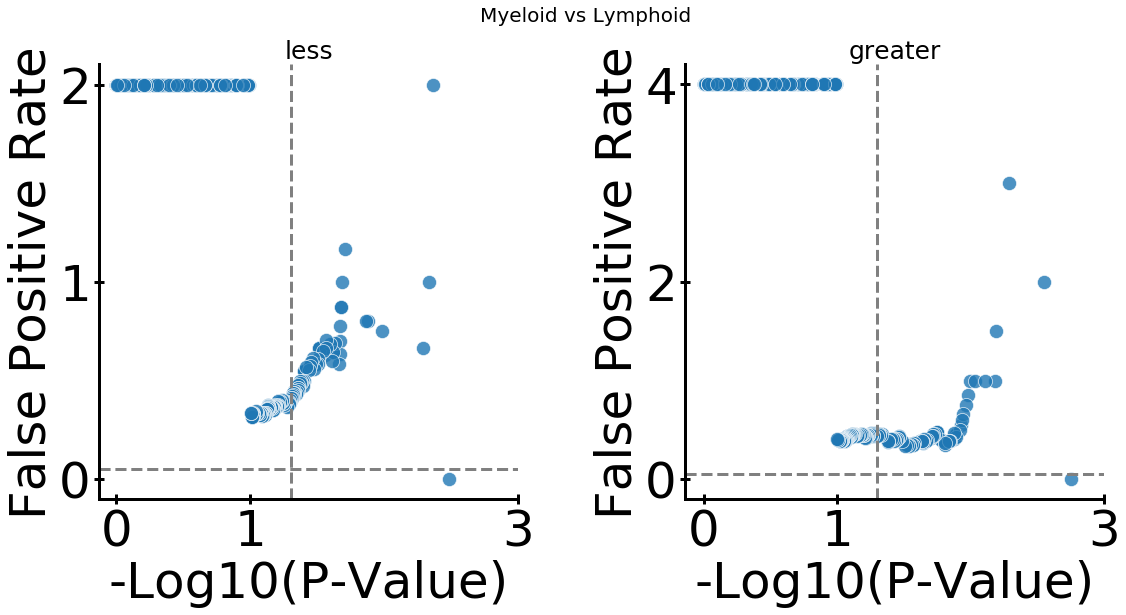

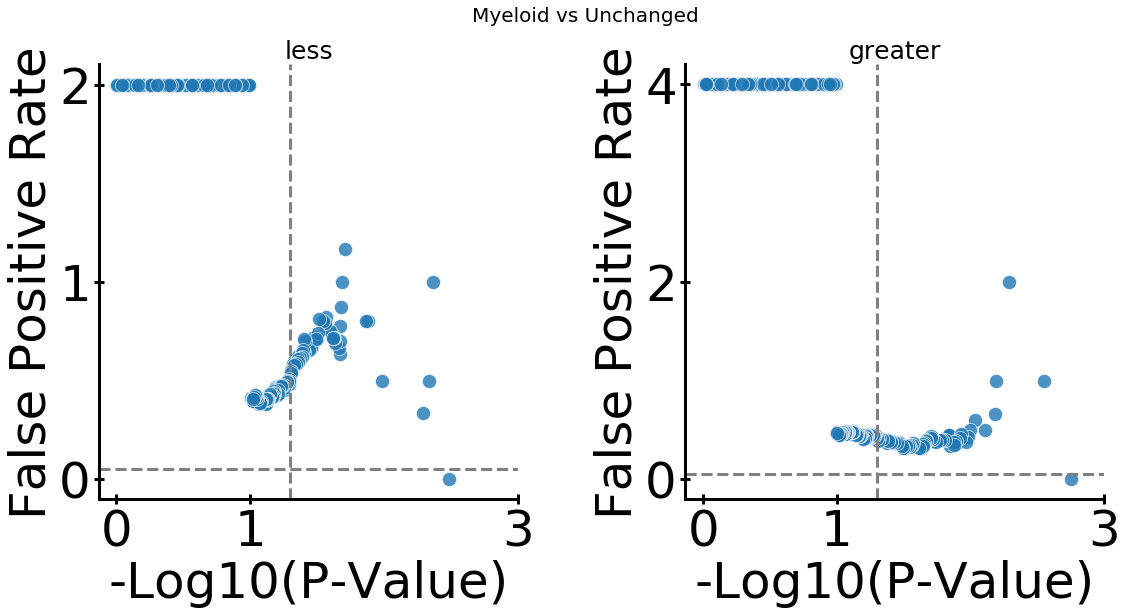

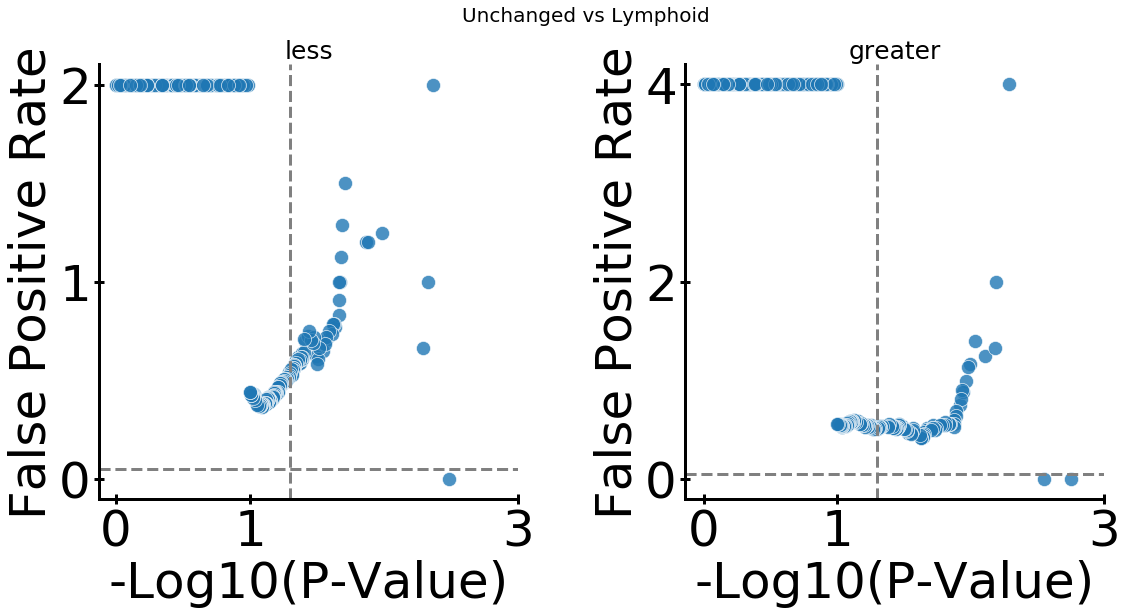

In [53]:
importlib.reload(rna)
experiment_with_fpr_df = rna.calc_fpr_both_directions(comparison_df, p_value_cutoff=0.1)
experiment_with_fpr_df = rna.add_mouse_gene_names(experiment_with_fpr_df)
mpl.rcParams['font.size'] = 50

for comp, c_df in experiment_with_fpr_df.groupby('comparison'):
    fig, axes = rna.plot_false_positive_scores(c_df)
    plt.suptitle(comp, fontsize=20)

In [54]:
pass_fpr_and_p_df = rna.filt_false_positive_p(experiment_with_fpr_df)
pass_fpr_and_p_df[['comparison', 'gene_name','p_value_greater', 'p_value_less', 'log2fc', 'fold_change', 'p_value_greater_fpr', 'p_value_less_fpr']].dropna()

,comparison,gene_name,p_value_greater,p_value_less,log2fc,fold_change,p_value_greater_fpr,p_value_less_fpr
703,Myeloid vs Lymphoid,Mpo,0.001750,0.999412,1.193916,2.287728,0.0,2.0
1329,Unchanged vs Lymphoid,Ngp,0.996791,0.003284,-0.623815,0.648953,4.0,0.0


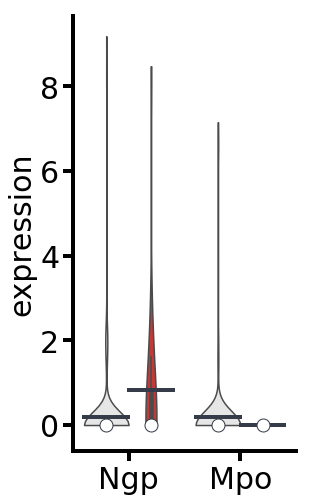

In [55]:
sig_genes = pass_fpr_and_p_df[['comparison','gene_name', 'gene_id', 'fold_change']].dropna()
sig_genes = sig_genes[sig_genes.gene_name != 'Xist']
sig_gene_expression = experiment_rna_data_df.merge(
    sig_genes,
    how='inner',
    validate='m:m'
)
importlib.reload(rna)
mpl.rcParams['font.size'] = 30
rna.plot_sig_genes(
    sig_gene_expression,
    comp=['Unchanged', 'Lymphoid'],
    palette=COLOR_PALETTES['change_type'],
    linewidth=4
)

## Compare Stable clones E-MOLD vs D-MOLD

In [22]:
unchanged_labels = change_labels[change_labels.change_status == 'Unchanged'][['code', 'group']]\
    .rename(columns={'group': 'label_name'})
group_stable_labels = unchanged_labels.label_name.unique()
label_comparisons = list(combinations(group_stable_labels, 2))
unchanged_labels.groupby('label_name').code.nunique()

label_name
aging_phenotype    446
no_change          350
Name: code, dtype: int64

In [23]:
importlib.reload(rna)
print(label_comparisons)
comparison_df, mapped_clones, experiment_rna_data_df = rna.generate_rna_seq_label_comparison_df(
    experiment_data_dir,
    scramble_data_dir,
    replicates,
    n_scrambles=5,
    labels_df=unchanged_labels,
    label_comparisons=label_comparisons,
    filter_genes=True,
    filter_genes_path=gene_list_file_name
)

[('aging_phenotype', 'no_change')]
Filtering Genes Using List From: /Users/akre96/Data/HSC_aging_project/aging_and_10x/rna_seq/filtered_gene_lists/filtered_gene-list_pcells-0.5_umicount-3_len-535.npy
Working on: AN8 experiment ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('aging_phenotype', 'no_change')
		 TWO LABELS NOT FOUND, ONLY SAW: ['aging_phenotype']
Done.
Working on: AN8 scramble-0 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('aging_phenotype', 'no_change')
		 TWO LABELS NOT FOUND, ONLY SAW: ['aging_phenotype']
Done.
Working on: AN8 scramble-1 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...Comparing: ('aging_phenotype', 'no_change')
		 TWO LABELS NOT FOUND, ONLY SAW: ['aging_phenotype']
Done.
Working on: AN8 scramble-2 ...
	...Importing Data
		 Before filtering genes: 555390
		 After filtering genes:  27285
	...C

In [24]:
comparison_df[comparison_df.experiment_type == 'experiment'][['replicate', 'experiment_type' ,'comparison', 'count_0', 'count_1', 'l0', 'l1']].drop_duplicates().sort_values(by=['replicate', 'comparison'])

,replicate,experiment_type,comparison,count_0,count_1,l0,l1
0,AN9,experiment,aging_phenotype vs no_change,122,78,aging_phenotype,no_change


# of P-Values: 534
# of P-Values less than or equal to  0.1 55
# of P-Values: 534
# of P-Values less than or equal to  0.1 52
Time Elapsed: 0.29684199999999805 seconds


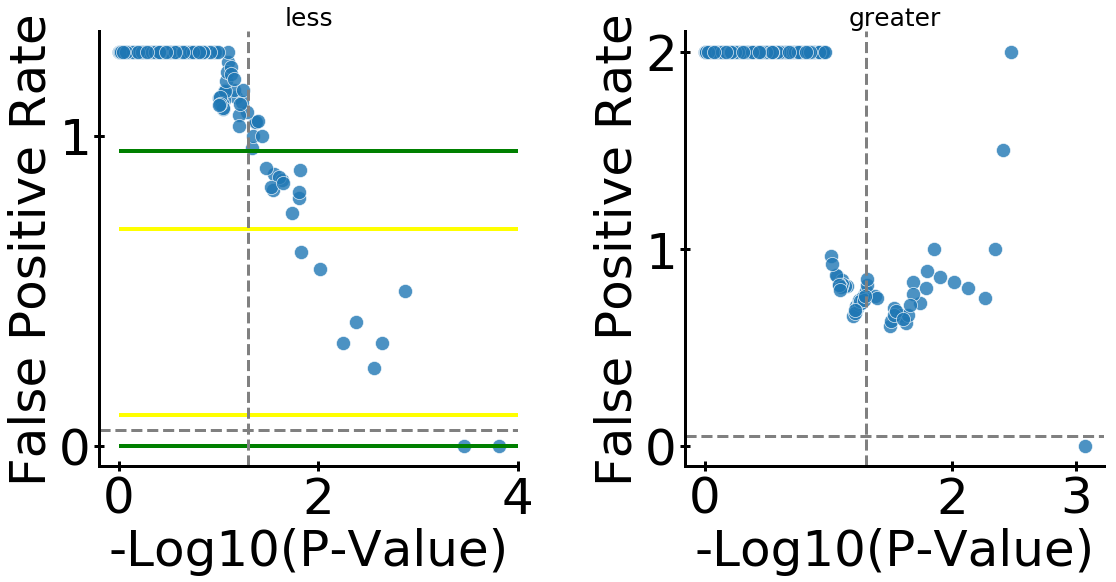

In [34]:
importlib.reload(rna)
experiment_with_fpr_df = rna.calc_fpr_both_directions(comparison_df, p_value_cutoff=0.1)
experiment_with_fpr_df = rna.add_mouse_gene_names(experiment_with_fpr_df)
mpl.rcParams['font.size'] = 50
fig, axes = rna.plot_false_positive_scores(experiment_with_fpr_df)
yellow_FPR = [.1, .7]
green_FPR = [0, .95]

axes[0].hlines(yellow_FPR, 0, 4, color='yellow', lw=4)
axes[0].hlines(green_FPR, 0, 4, color='green', lw=4)

In [15]:
pass_fpr_and_p_df = rna.filt_false_positive_p(experiment_with_fpr_df)
pass_fpr_and_p_df[['comparison', 'gene_name','p_value_greater', 'p_value_less', 'log2fc', 'fold_change', 'p_value_greater_fpr', 'p_value_less_fpr']]

,comparison,gene_name,p_value_greater,p_value_less,log2fc,fold_change,p_value_greater_fpr,p_value_less_fpr
42,aging_phenotype vs no_change,Rps18,0.999847,0.000154,-0.175647,0.885371,2.0,0.00000
85,aging_phenotype vs no_change,Timm13,0.000849,0.999159,0.511492,1.425523,0.0,1.27027
406,aging_phenotype vs no_change,Rpl32,0.999659,0.000344,-0.156289,0.897330,2.0,0.00000


In [38]:
green_box = experiment_with_fpr_df[
    (experiment_with_fpr_df.p_value_less_fpr >= green_FPR[0]) &
    (experiment_with_fpr_df.p_value_less_fpr <= green_FPR[1])
]
yellow_box = experiment_with_fpr_df[
    (experiment_with_fpr_df.p_value_less_fpr >= yellow_FPR[0]) &
    (experiment_with_fpr_df.p_value_less_fpr <= yellow_FPR[1])
]
yellow_box[['comparison', 'gene_name','p_value_greater', 'p_value_less', 'log2fc', 'fold_change', 'p_value_greater_fpr', 'p_value_less_fpr']]

,comparison,gene_name,p_value_greater,p_value_less,log2fc,fold_change,p_value_greater_fpr,p_value_less_fpr
25,aging_phenotype vs no_change,Etfb,0.997287,0.002734,-0.451214,0.731427,2.0,0.250000
70,aging_phenotype vs no_change,Hist1h2bc,0.994472,0.005594,-0.254719,0.838150,2.0,0.333333
268,aging_phenotype vs no_change,Rac2,0.995883,0.004148,-0.449894,0.732097,2.0,0.400000
306,aging_phenotype vs no_change,Txnip,0.990482,0.009590,-0.395653,0.760145,2.0,0.571429
310,aging_phenotype vs no_change,Trmt112,0.985357,0.014739,-0.371983,0.772720,2.0,0.625000
418,aging_phenotype vs no_change,Rpl11,0.998681,0.001330,-0.204436,0.867878,2.0,0.500000
495,aging_phenotype vs no_change,Hspe1,0.997718,0.002300,-0.455353,0.729332,2.0,0.333333


In [49]:
for g in green_box.gene_id.unique():
    print(g)

ENSMUSG00000004610
ENSMUSG00000008668
ENSMUSG00000012848
ENSMUSG00000018102
ENSMUSG00000027562
ENSMUSG00000033220
ENSMUSG00000037563
ENSMUSG00000038393
ENSMUSG00000038812
ENSMUSG00000041841
ENSMUSG00000048758
ENSMUSG00000057841
ENSMUSG00000059291
ENSMUSG00000060636
ENSMUSG00000063856
ENSMUSG00000067288
ENSMUSG00000069516
ENSMUSG00000073676
ENSMUSG00000073940
ENSMUSG00000079641


In [16]:
sig_genes = pass_fpr_and_p_df[['comparison','gene_name', 'gene_id', 'fold_change']]
sig_genes = sig_genes[sig_genes.gene_name != 'Xist']
sig_gene_expression = experiment_rna_data_df.merge(
    sig_genes,
    how='inner',
    validate='m:m'
)

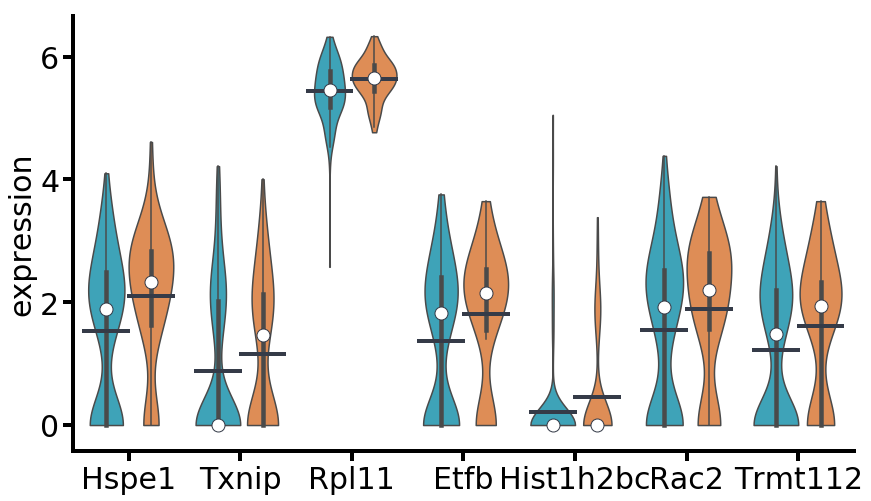

In [37]:
yellow_genes = yellow_box[['comparison','gene_name', 'gene_id', 'fold_change']]
yellow_gene_expression = experiment_rna_data_df.merge(
    yellow_genes,
    how='inner',
    validate='m:m'
)

importlib.reload(rna)
mpl.rcParams['font.size'] = 30
rna.plot_sig_genes(
    yellow_gene_expression,
    comp=['aging_phenotype', 'no_change'],
    palette=COLOR_PALETTES['group'],
    linewidth=4
)

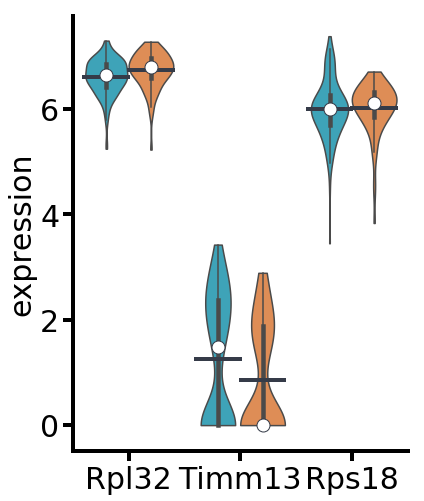

In [18]:
importlib.reload(rna)
mpl.rcParams['font.size'] = 30
rna.plot_sig_genes(
    sig_gene_expression,
    comp=['aging_phenotype', 'no_change'],
    palette=COLOR_PALETTES['group'],
    linewidth=4
)